In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as LR


# 1. Modelling CPU- GPU communications

In [2]:
h2d=pd.read_csv("./pa6_h2dd2h.csv", names=['size', 'h2d', 'd2h'])

In [35]:
h2d.groupby('size').mean().astype(int)

h2d     d2h  h2dbw  d2hbw
size                                   
1000           15      11    202    104
2000            6       9    341    202
4000            7      11    507    342
8000           13      24    616    321
16000          23      34    691    462
32000          31      54   1012    584
64000          58     100   1088    638
128000        114     198   1118    644
256000        225     413   1137    618
512000        479     756   1068    676
1024000       991    1393   1033    734
2048000      2006    2682   1020    763
4096000      4041    5277   1013    776
8192000      8105   10498   1010    780
16384000    16218   20916   1010    783
32768000    32408   41823   1011    783
65536000    64863   83880   1010    781
131072000  129813  167580   1009    782
262144000  259522  334982   1010    782
524288000  519049  669749   1010    782

In [3]:
h2d['h2dbw']=h2d['size']/h2d['h2d']
h2d['d2hbw']=h2d['size']/h2d['d2h']

## Device to Host time versus size ( Example)

<AxesSubplot:xlabel='size', ylabel='d2h'>

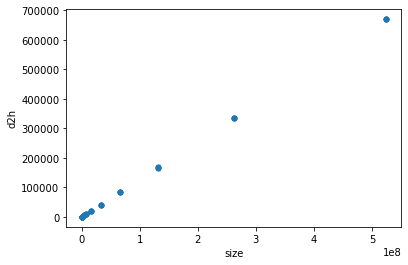

In [47]:
h2d.plot(x='size', y='d2h', kind='scatter')

## Device to Host bandwidth versus size (example)

<AxesSubplot:xlabel='size', ylabel='[d2hbw]'>

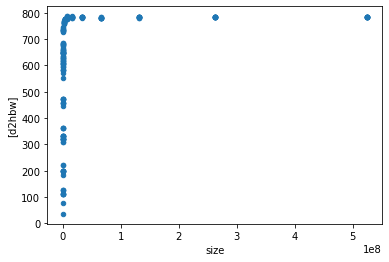

In [50]:
h2d.plot(x='size', y=['d2hbw'], kind='scatter')

## Coefficient and Intercept values for different graphs

In [122]:
n = { "h2d":"Host to device", "d2h":"Device to Host", "h2dbw":"Host to device bandwidth", "d2hbw":"Device to host bandwidth"}
commreg=dict()

for i in ['h2d','d2h','h2dbw','d2hbw']:
    commreg[i]=dict()
    X=h2d['size']
    y2=h2d[i]
    s=LR.LinearRegression().fit(np.array(X).reshape(-1,1),y2)
    print(n[i] + " versus size :  y = "+ str(s.coef_)+"*x + "+ str(s.intercept_))
    commreg[i]['coef']=s.coef_
    commreg[i]['intercept']=s.intercept_

Host to device versus size :  y = [0.00099004]*x + -6.648686671534961
Device to Host versus size :  y = [0.00127748]*x + 43.52317791923997
Host to device bandwidth versus size :  y = [3.8362262e-07]*x + 876.1382202873783
Device to host bandwidth versus size :  y = [5.55236641e-07]*x + 588.2653547951022


# 2. Modelling kernel time

In [95]:
ker=pd.read_csv("./flops_bytes.csv")

In [96]:
fdict = dict(zip(ker['kernel'],ker['flops']))
bdict = dict(zip(ker['kernel'],ker['bytes']))
bdict['magdir']=bdict['mag']+bdict['dir']
fdict['magdir']=fdict['mag']+fdict['dir']
fdict['hysteresis']=fdict['hyst']
bdict['hysteresis']=bdict['hyst']

In [97]:
fdict

{'conv': 80,
 'mag': 7,
 'dir': 5,
 'supp': 23,
 'hyst': 11,
 'edge': 28,
 'magdir': 12,
 'hysteresis': 11}

In [98]:
bdict

{'conv': 126,
 'mag': 9,
 'dir': 6,
 'supp': 36,
 'hyst': 17,
 'edge': 69,
 'magdir': 15,
 'hysteresis': 17}

In [99]:
gpu=pd.read_csv('./pa5_4.csv', names=['size', 'sigma', 'blocksize' , 'comp', 'e2e','h2d', 'conv','magdir','supp','sort','hysteresis','edge','d2h','malloc','cudamalloc','cudafree'])
gputest=pd.read_csv('./pa5_5.csv', names=['size', 'sigma', 'blocksize' , 'comp', 'e2e','h2d', 'conv','magdir','supp','sort','hysteresis','edge','d2h','malloc','cudamalloc','cudafree'])


In [100]:
gpu[gpu['blocksize']==32].iloc[:5,:]

size  sigma  blocksize  comp     e2e  h2d  conv  magdir  supp  sort  \
20   256    0.6         32  1787  159838  148   119      28    33   255   
21   256    0.6         32  1942  167741  184   129      31    34   273   
22   256    0.6         32  1712  155921  143   117      27    36   252   
23   256    0.6         32  1509  133261  121   105      26    34   241   
24   256    0.6         32  1745  154326  146   117      27    33   250   

    hysteresis  edge   d2h  malloc  cudamalloc  cudafree  
20          35    20  2729      97      151438         1  
21          35    24  2997      82      158680         1  
22          33    19  2660      89      148043         0  
23          41    19  2231      99      126383         0  
24          33    20  2583      81      146546         0

In [101]:
gpu.dtypes

size            int64
sigma         float64
blocksize       int64
comp            int64
e2e             int64
h2d             int64
conv            int64
magdir          int64
supp            int64
sort            int64
hysteresis      int64
edge            int64
d2h             int64
malloc          int64
cudamalloc      int64
cudafree        int64
dtype: object

In [102]:
kernel_data=pd.DataFrame()
reg=pd.DataFrame(columns=['kernel','blocksize','FLOPS_kernel_coef','BYTES_kernel_coef','intercept'])

In [103]:
gpu2=gpu.groupby(['size','blocksize']).mean().reset_index().astype(int)

In [104]:
kernelnames=['conv','magdir','supp','hysteresis','edge']
blocksize=[8,16,32]

In [105]:
gpu2[gpu2['blocksize']==b].reset_index()

index   size  blocksize  sigma     comp      e2e     h2d   conv  magdir  \
0      2    256         32      0     1727   152582     145    116      27   
1      5    512         32      0     6567   166913     628    268      58   
2      8   1024         32      0    20123   217335    1900    673     165   
3     11   2048         32      0    60230   353864    5753   2278     592   
4     14   4096         32      0   221020  1102305   21134   8874    2320   
5     17   8192         32      0   868676  3462621   71987  35959    9399   
6     20  10240         32      0  1322196  5613821  110498  56160   14288   

    supp   sort  hysteresis   edge      d2h  malloc  cudamalloc  cudafree  
0     33    252          34     20     2624      87      144706         0  
1    101    916         115     42    10166      81      140157         0  
2    354   1380         172    134    27527      82      143769         0  
3   1351   2933         397    502    75502      84      135123         0  
4   5676   8944        1332   2056   293122      80      134018         0  
5  23519  32704        4274   7198   954169      71      120501         0  
6  32445  49599        6680  10999  1432992      65      119009         0

In [106]:
for k in kernelnames:
    for b in blocksize:
        gpu_ = gpu2[gpu2['blocksize']==b].reset_index()
        kernel_data=pd.DataFrame()
        kernel_data['threads']=gpu_['size']*gpu_['size']
        kernel_data['fl']=fdict[k]
        kernel_data['by']=bdict[k]
        kernel_data['flops']=kernel_data['threads']*kernel_data['fl']
        kernel_data['bytes']=kernel_data['threads']*kernel_data['by']
        kernel_data['avgtime']=gpu_[k]
        X=kernel_data[['flops','bytes']]
        y=kernel_data['avgtime']
        try:
            s=LR.LinearRegression().fit(np.array(X),y)
        except:
            print(k,b)
            print(X)
            break
        reg.loc[len(reg.index)] = [k,b,s.coef_[0],s.coef_[1],s.intercept_]

In [107]:
reg

kernel blocksize  FLOPS_kernel_coef  BYTES_kernel_coef   intercept
0         conv         8       1.783685e-06           0.000003   14.933112
1         conv        16       1.788743e-06           0.000003   47.977667
2         conv        32       1.920826e-06           0.000003   56.893293
3       magdir         8       4.197172e-06           0.000005   23.030099
4       magdir        16       4.204464e-06           0.000005   26.520500
5       magdir        32       4.454576e-06           0.000006   33.169334
6         supp         8       3.561329e-06           0.000006  100.566754
7         supp        16       3.573366e-06           0.000006  124.196280
8         supp        32       4.020792e-06           0.000006  212.110625
9   hysteresis         8       1.191515e-06           0.000002  106.329604
10  hysteresis        16       1.309582e-06           0.000002  109.599330
11  hysteresis        32       1.677364e-06           0.000003  122.212604
12        edge         8       5.249023e-07           0.000001   57.307293
13        edge        16       5.089539e-07           0.000001   65.123681
14        edge        32       5.297358e-07           0.000001   80.879121

# Sort time modelling

In [110]:
sortd=pd.read_csv("s4.csv",names=['size','time'])

<AxesSubplot:xlabel='size', ylabel='time'>

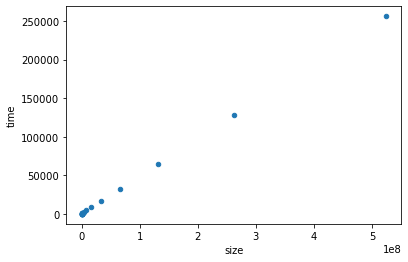

In [115]:
sortd.plot(x='size', y='time', kind='scatter')

In [121]:
X=sortd['size']
y=sortd['time']
s=LR.LinearRegression().fit(np.array(X).reshape(-1,1),y)
print(" Size vs time sorting: y = " +str(s.coef_)+" *x + "+str(s.intercept_))
sortreg=dict()
sortreg['coef']=s.coef_
sortreg['intercept']=s.intercept_

 Size vs time sorting: y = [0.0004881] *x + 591.3404184885658


# 4. Prediction 

The gpu canny edge code has
- 1 major h2d communication
- 9 major d2h communications
- kernel calls
- sort call


In [139]:
def predicted_time(size, blocksize):
    ret=dict()
    ret['h2d']=commreg['h2d']['coef']*size*size + commreg['h2d']['intercept']
    ret['d2h']=9*(commreg['d2h']['coef']*size*size + commreg['d2h']['intercept'] )
    for i in ['conv','magdir','supp','hysteresis','edge']:
        ret[i] = fdict[i]*size*size*float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['FLOPS_kernel_coef'])
        ret[i] += bdict[i]*size*size*float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['BYTES_kernel_coef'])
        ret[i] += float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['intercept'])
    ret['sort']=sortreg['coef']*size*size+sortreg['intercept']
    return ret

In [140]:
a = predicted_time(1000, 8)

<ipython-input-139-3fdecaa4935b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret[i] = fdict[i]*size*size*float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['FLOPS_kernel_coef'])
<ipython-input-139-3fdecaa4935b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret[i] += bdict[i]*size*size*float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['BYTES_kernel_coef'])
<ipython-input-139-3fdecaa4935b>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret[i] += float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['intercept'])


In [146]:
prediction_df=pd.DataFrame(columns=['size','blocksize','h2d','d2h','conv','magdir','supp','sort', 'hysteresis','edge'])
for size in 3072, 5120, 7680:
    for blocksize in 8, 16, 32:
        a=predicted_time(size, blocksize)
        a['size']=size
        a['blocksize']=blocksize
        prediction_df.loc[len(prediction_df.index)] = [ a[i] for i in ['size','blocksize','h2d','d2h','conv','magdir','supp','sort', 'hysteresis','edge'] ]


<ipython-input-139-3fdecaa4935b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret[i] = fdict[i]*size*size*float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['FLOPS_kernel_coef'])
<ipython-input-139-3fdecaa4935b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret[i] += bdict[i]*size*size*float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['BYTES_kernel_coef'])
<ipython-input-139-3fdecaa4935b>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret[i] += float(reg[reg['blocksize']==blocksize][reg['kernel']==i]['intercept'])


In [154]:
prediction_df=prediction_df.astype(float)

In [155]:
gputest= gputest.groupby(['size','blocksize']).mean().reset_index()

In [159]:
prediction_df.astype(int)

size  blocksize    h2d     d2h   conv  magdir   supp   sort  hysteresis  \
0  3072          8   9336  108893   4702    1241   2767   5197         525   
1  3072         16   9336  108893   4748    1246   2800   5197         570   
2  3072         32   9336  108893   5104    1325   3222   5197         712   
3  5120          8  25946  301786  13034    3406   7508  13386        1270   
4  5120         16  25946  301786  13104    3415   7556  13386        1389   
5  5120         32  25946  301786  14077    3623   8575  13386        1761   
6  7680          8  58388  678529  29309    7635  16768  29380        2725   
7  7680         16  58388  678529  29425    7652  16847  29380        2988   
8  7680         32  58388  678529  31603    8112  19029  29380        3809   

   edge  
0  1038  
1  1016  
2  1070  
3  2782  
4  2707  
5  2830  
6  6188  
7  6010  
8  6268

In [160]:
gputest[['size','blocksize','h2d','d2h','conv','magdir','supp','sort', 'hysteresis','edge']].astype(int)

size  blocksize    h2d     d2h   conv  magdir   supp   sort  hysteresis  \
0  3072          8  12694  166310   4548    1216   2570   5426         575   
1  3072         16  12494  165094   4564    1217   2615   5423         635   
2  3072         32  12514  166412   4964    1294   2984   5433         779   
3  5120          8  32367  454643  12466    3383   7509  13379        1434   
4  5120         16  30670  428716  12994    3434   7806  13676        1596   
5  5120         32  31672  443723  14093    3673   9028  13696        2056   
6  7680          8  63721  819303  29319    7699  17669  29030        3014   
7  7680         16  64091  807986  29403    7708  17754  29001        3288   
8  7680         32  64946  848075  31567    8231  20114  29041        4122   

   edge  
0  1071  
1  1037  
2  1126  
3  3098  
4  3084  
5  3308  
6  6889  
7  6739  
8  6849

In [ ]:
for size in 